In [2]:
!pip show torch torchvision 

Name: torch
Version: 2.9.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org
Author: 
Author-email: PyTorch Team <packages@pytorch.org>
License: BSD-3-Clause
Location: /opt/anaconda3/lib/python3.13/site-packages
Requires: filelock, fsspec, jinja2, networkx, setuptools, sympy, typing-extensions
Required-by: torchvision
---
Name: torchvision
Version: 0.24.0
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /opt/anaconda3/lib/python3.13/site-packages
Requires: numpy, pillow, torch
Required-by: 


In [10]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from tqdm.auto import tqdm 

import torch 
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.optim as optim 

from torchvision.models import resnet50 , ResNet50_Weights


In [11]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
#Downloads/archive/carpet/train
train_image_path=Path('archive/carpet/train')

good_dataset = ImageFolder(root=train_image_path,transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(good_dataset,[0.8,0.2])

BS=16

train_loader = DataLoader(train_dataset, batch_size=BS, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle= True)

In [12]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)

In [13]:
for name, param in resnet_model.named_parameters():
    print(name, param.shape)
# For a ResNet model, it contains:
# Weights of each convolution layerre
# Bias of each convolution layer (if present)
# BatchNorm weights and biases
# Fully connected (FC) layer weights and biases
# Downsample block parameters

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
layer1.0.bn3.weight torch.Size([256])
layer1.0.bn3.bias torch.Size([256])
layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
layer1.0.downsample.1.weight torch.Size([256])
layer1.0.downsample.1.bias torch.Size([256])
layer1.1.conv1.weight torch.Size([64, 256, 1, 1])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer1.1.conv3.weight torch.Size([256, 64, 1, 1])
layer1.1.bn3.weight torch.Size([256])
layer1.1.bn3.bias torch.Size([256])
layer1.2.conv1.weight tor

In [14]:
# def hook(model,input,output):
#     feature.append(output.detach())

# feature=[]
# resnet_model.layer2[-1].register_forward_hook(hook)
# resnet_model.layer3[-1].register_forward_hook(hook)


# _= resnet_model(torch.randn(1,3,224,224))

# feature[0].shape
# feature[1].shape

In [15]:
# class basicallly for extracting the feature maps from the pretrained model Resnet50
class resnet_feature_extractor(torch.nn.Module):
    def __init__(self):
        super(resnet_feature_extractor,self).__init__()
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)

        self.model.eval()
        for p in self.model.parameters():
            p.requires_grad = False


        #hook to extract the feature maps

        def hook(module, input ,output)-> None:
            # this hook saves the extracted features map on self.forward
            self.features.append(output.detach())

        self.model.layer2[-1].register_forward_hook(hook)
        self.model.layer3[-1].register_forward_hook(hook)

    def forward(self,input):
        self.features=[]
        with torch.no_grad():  # torch.no_grad() is for the It temporarily turns off gradient calculation, meaning: No .grad is stored , No computation graph is built , Much lower memory use Faster inference
            _=self.model(input)

        self.avg=torch.nn.AvgPool2d(3,stride=1)
        fmap_size=self.features[0].shape[-2] #feature map sizes h,w 
        self.resize = torch.nn.AdaptiveAvgPool2d(fmap_size)

        resized_maps=[self.resize(self.avg(fmap)) for fmap in self.features]
        patch=torch.cat(resized_maps,1)

        return patch

torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])
torch.Size([1, 1536, 28, 28])


torch.Size([1, 3, 224, 224])

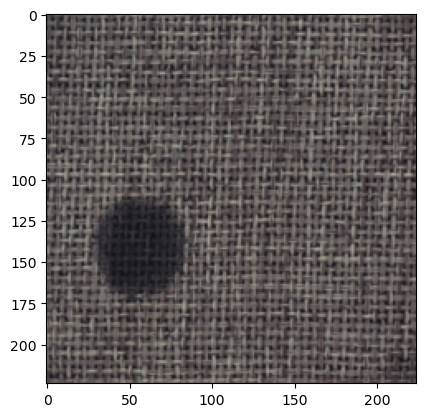

In [16]:
image=Image.open('/Users/mrinalseth13331/Downloads/archive/carpet/test/color/000.png')
image=transform(image).unsqueeze(0)

backbone = resnet_feature_extractor()
feature = backbone(image)

print(backbone.features[0].shape)
print(backbone.features[1].shape)

print(feature.shape)

plt.imshow(image[0].permute(1,2,0))
image.shape

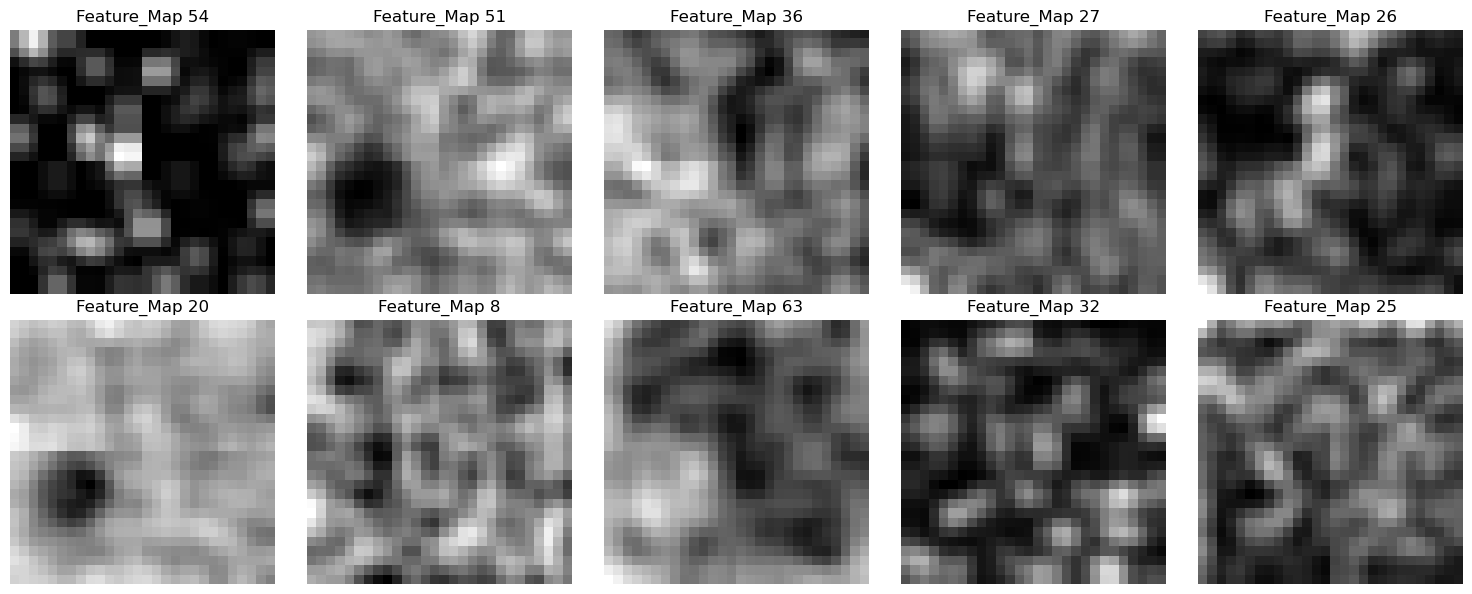

In [75]:
#Select10 random indices for the feature maps
indices=torch.randperm(64)[:10]

# Plot the selected the feature maps
fig,axes = plt.subplots(2,5,figsize=(15,6))

for i,idx in enumerate(indices):   # from the enumerate we get both the indices and the data
    row = i//5
    col=i%5
    axes[row,col].imshow(feature[0,idx].detach().cpu(),cmap='gray')
    axes[row,col].set_title(f'Feature_Map {idx}')
    axes[row,col].axis('off')
plt.tight_layout()
plt.show()


# THE AUTOENCODER MODEL TAKEN FROM THE PAPER

Unsupervised anomaly segmentation via deep feature reconstruction

In [17]:
import torch.nn as nn

class FeatCAE(nn.Module):
    """Autoencoder."""

    def __init__(self, in_channels=1000, latent_dim=50, is_bn=True):
        super(FeatCAE, self).__init__()

        layers = []
        layers += [nn.Conv2d(in_channels, (in_channels + 2 * latent_dim) // 2, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=(in_channels + 2 * latent_dim) // 2)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d((in_channels + 2 * latent_dim) // 2, 2 * latent_dim, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=2 * latent_dim)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d(2 * latent_dim, latent_dim, kernel_size=1, stride=1, padding=0)]

        self.encoder = nn.Sequential(*layers)

        # if 1x1 conv to reconstruct the rgb values, we try to learn a linear combination
        # of the features for rgb
        layers = []
        layers += [nn.Conv2d(latent_dim, 2 * latent_dim, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=2 * latent_dim)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d(2 * latent_dim, (in_channels + 2 * latent_dim) // 2, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=(in_channels + 2 * latent_dim) // 2)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d((in_channels + 2 * latent_dim) // 2, in_channels, kernel_size=1, stride=1, padding=0)]
        # layers += [nn.ReLU()]

        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [18]:


device = torch.device("cpu")
model = FeatCAE(in_channels=1536, latent_dim=100).to(device)
backbone = backbone.to(device)

# DEFINE LOSS FUNCTION AND OPTIMIZER
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)



In [102]:
# Verify model is fully on CPU
for name, p in model.named_parameters():
    assert p.device.type == "cpu", f"Model parameter {name} is on {p.device}"

# Verify backbone is fully on CPU
for name, p in backbone.named_parameters():
    assert p.device.type == "cpu", f"Backbone parameter {name} is on {p.device}"


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Loss: 0.0832, Validation Loss: 0.2141
Epoch [6/50], Loss: 0.0350, Validation Loss: 0.0349
Epoch [11/50], Loss: 0.0335, Validation Loss: 0.0332
Epoch [16/50], Loss: 0.0309, Validation Loss: 0.0313
Epoch [21/50], Loss: 0.0286, Validation Loss: 0.0289
Epoch [26/50], Loss: 0.0266, Validation Loss: 0.0267
Epoch [31/50], Loss: 0.0256, Validation Loss: 0.0258
Epoch [36/50], Loss: 0.0249, Validation Loss: 0.0246
Epoch [41/50], Loss: 0.0238, Validation Loss: 0.0242
Epoch [46/50], Loss: 0.0248, Validation Loss: 0.0237


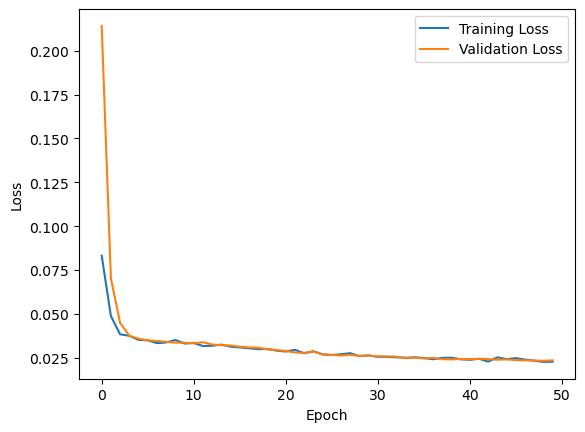

In [104]:
Loss = []
Validation_Loss = []

num_epochs = 50

for epoch in tqdm(range(num_epochs)):
    model.train()

    for data, _ in train_loader:
        data = data.to(device).float()     

        with torch.no_grad():
            features = backbone(data)      

        # Forward pass
        output = model(features)           

        # Compute loss
        loss = criterion(output, features)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    Loss.append(loss.item())

    # Validation
    val_loss_sum = 0.0
    num_batches = 0
    model.eval()

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device).float()

            features = backbone(data)
            output = model(features)

            val_loss = criterion(output, features)
            val_loss_sum += val_loss.item()
            num_batches += 1

    val_loss_avg = val_loss_sum / num_batches
    Validation_Loss.append(val_loss_avg)

    if epoch % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Loss: {loss.item():.4f}, Validation Loss: {val_loss_avg:.4f}")

plt.plot(Loss, label='Training Loss')
plt.plot(Validation_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [105]:
torch.save(model.state_dict(), 'autoencoder_with_resnet_deep_features.pth')


In [19]:
ckpoints = torch.load('autoencoder_with_resnet_deep_features.pth')
model.load_state_dict(ckpoints)

model.eval()

FeatCAE(
  (encoder): Sequential(
    (0): Conv2d(1536, 868, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(868, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(868, 200, kernel_size=(1, 1), stride=(1, 1))
    (4): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(200, 100, kernel_size=(1, 1), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): Conv2d(100, 200, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(200, 868, kernel_size=(1, 1), stride=(1, 1))
    (4): BatchNorm2d(868, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(868, 1536, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [96]:

# device = torch.device("cpu")
# print("Using device:", device)

# # Move CAE to CPU
# model = model.to(device).float()

# # Move backbone or extractor to CPU
# backbone = backbone.to(device)

# # If backbone contains internal .model (like in your hook extractor class)
# if hasattr(backbone, "model"):
#     backbone.model = backbone.model.to(device).float()


# this was done as thier was error for the mps in for calulcation in betwen the tensor

Using device: cpu


## Prediction of the Heatmap



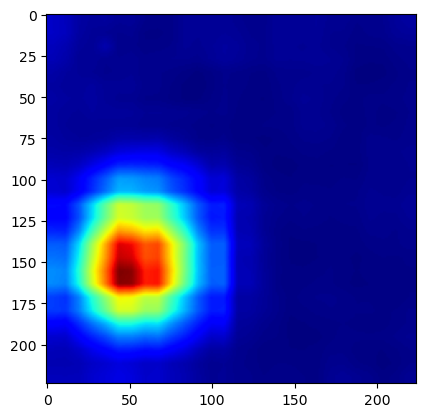

In [24]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

image = Image.open("/Users/mrinalseth13331/Downloads/archive/carpet/test/color/000.png")
image = transform(image).unsqueeze(0)

with torch.no_grad():
    features = backbone(image.to(device))
    recon = model(features)

# Compute reconstruction error
recon_error = ((features - recon) ** 2).mean(dim=1, keepdim=True)   # [1,1,h,w]

# Upscale heatmap to 224×224
segm_map = F.interpolate(
    recon_error,
    size=(224, 224),
    mode='bilinear',
    align_corners=False
)

# Convert to numpy correctly
heatmap = segm_map.squeeze().cpu().numpy()

# Visualize
plt.imshow(heatmap, cmap='jet')
plt.show()


To get the single value for the segment value we are taking the top k valuesa sit could be highly snesitive to the oultiers 

# For Ok Images

In [28]:
def decision_function(seg_map):

    mean_top_10_values=[]

    for map in seg_map:

        # flatten the tensor
        flattened_tensor = map.reshape(-1)

        #sort the flattened tensor along the featrue dimension (descending order)
        sorted_tensor,_ = torch.sort(flattened_tensor,descending=True)

        #take the top 10 values along the feature dimension
        mean_top_10_value = sorted_tensor[:10].mean()

        mean_top_10_values.append(mean_top_10_value)

    return torch.stack(mean_top_10_values)

In [29]:
model.eval() # to chaneg the mdoel to the inference mode

RECON_ERROR = []

for data, _ in train_loader:

    with torch.no_grad():
        data = data.to(device)
        features = backbone(data).squeeze()

        # Forward pass through model
        recon = model(features)

    # Compute segmentation error map
    # mean across channels
    segm_map = ((features - recon) ** 2).mean(dim=1, keepdim=True)

    # remomve the pixels from the border(from the latent space to the original during the transpose convolution during the edges it dont convert very well )
    segm_map = segm_map[:, :, 3:-3, 3:-3]

    # Compute anomaly score from top-10 heatmap values
    anomaly_score = decision_function(segm_map)

    RECON_ERROR.append(anomaly_score)

# Combine into single tensor and convert to numpy
RECON_ERROR = torch.cat(RECON_ERROR).cpu().numpy()


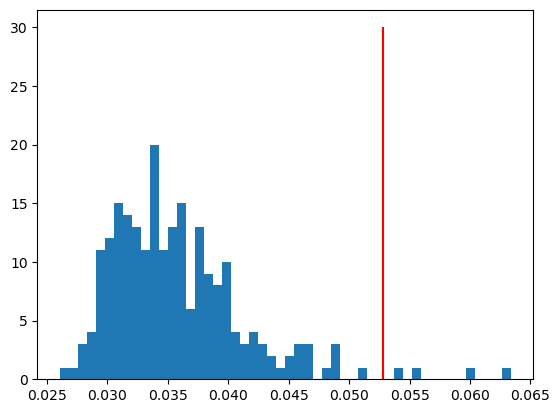

In [33]:
best_threshold = np.mean(RECON_ERROR) + 3*np.std(RECON_ERROR)

heat_map_max, heat_map_min = np.max(RECON_ERROR), np.min(RECON_ERROR)

plt.hist(RECON_ERROR,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

# For the defective images

In [45]:
y_true=[]
y_pred=[]
y_score=[]

model.eval()
backbone.eval()

test_path=Path('/Users/mrinalseth13331/Downloads/archive/carpet/test')

for path in test_path.glob('*/*.png'):
    fault_type = path.parts[-2]
    test_image = transform(Image.open(path)).to(device).unsqueeze(0)

    with torch.no_grad():
        features = backbone(test_image)
        #forward pass
        recon=model(features)

    segm_map = ((features - recon)**2).mean(dim=1, keepdim=True)
    segm_map = segm_map[:, :, 3:-3, 3:-3]  
    y_score_image = decision_function(seg_map=segm_map)
    # y_score_image = segm_map.mean(axis=(1,2))
    
    y_pred_image = 1*(y_score_image >= best_threshold)
    
    y_true_image = 0 if fault_type == 'good' else 1
    
    y_true.append(y_true_image)
    y_pred.append(y_pred_image.cpu().numpy())
    y_score.append(y_score_image.cpu().numpy())
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

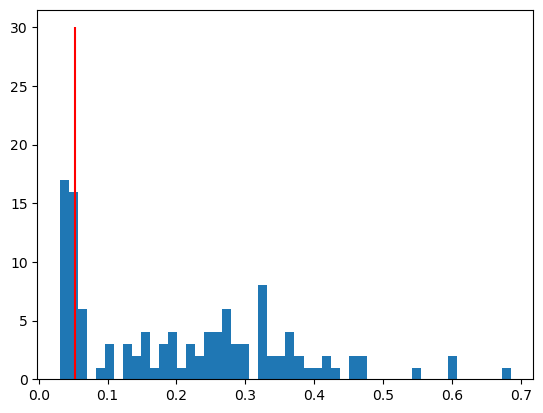

In [46]:
plt.hist(y_score,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

AUC-ROC Score: 0.9751203852327447


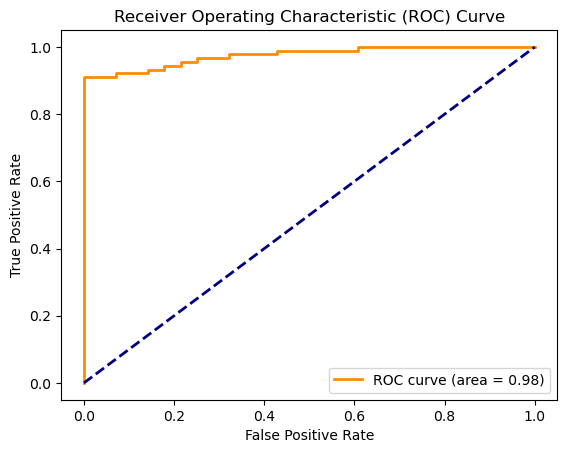

best_threshold = 0.06364603340625763


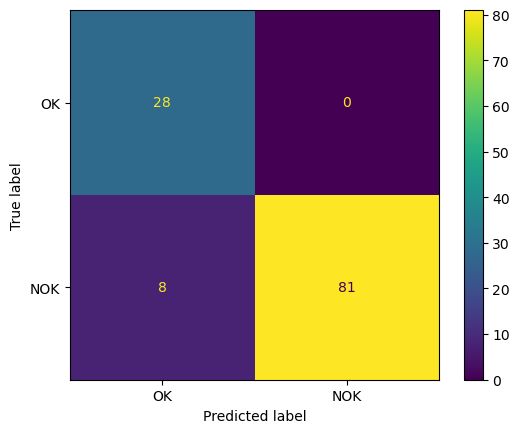

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score
import seaborn as sns



# Calculate AUC-ROC score
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



f1_scores = [f1_score(y_true, y_score >= threshold) for threshold in thresholds]

# Select the best threshold based on F1 score
best_threshold = thresholds[np.argmax(f1_scores)]

print(f'best_threshold = {best_threshold}')

# Generate confusion matrix
cm = confusion_matrix(y_true, (y_score >= best_threshold).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['OK','NOK'])
disp.plot()
plt.show()

#### to bring all back to the cpu


In [63]:
import torch

# choose device
device = torch.device("cpu") if torch.backends.mps.is_available() else torch.device("cpu")
print("Using device:", device)

# move models to device (DO THIS ONCE before eval/training)
model = model.to(device)
backbone = backbone.to(device)

# optional: set dtype explicitly if you have weird casts
model = model.to(dtype=torch.float32)
backbone = backbone.to(dtype=torch.float32)

# debug check: print where first param lives
def model_device(m):
    p = next(m.parameters())
    return p.device
print("model device:", model_device(model))
print("backbone device:", model_device(backbone))


Using device: cpu
model device: cpu
backbone device: cpu


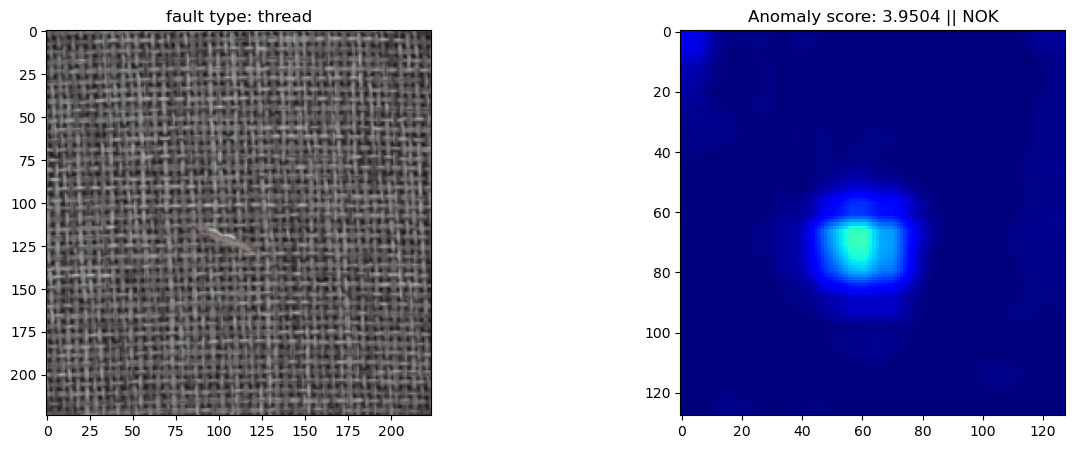

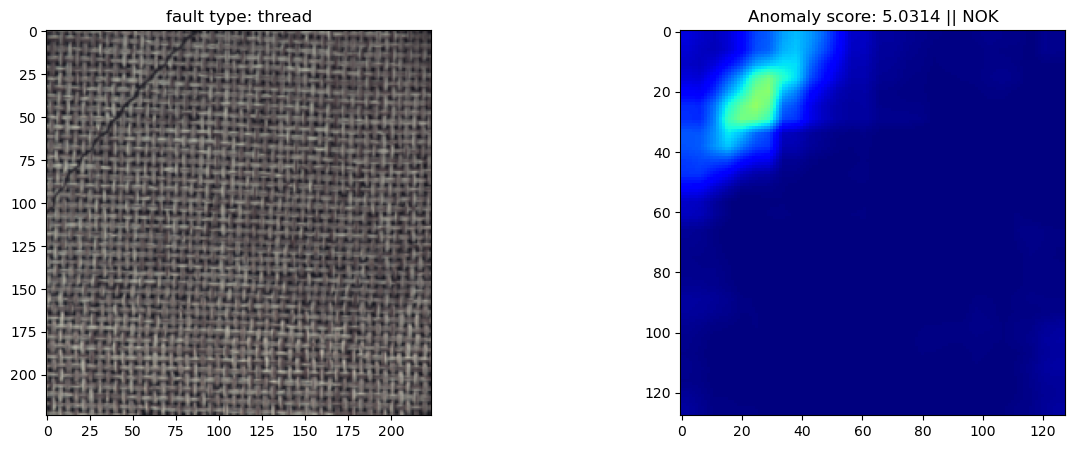

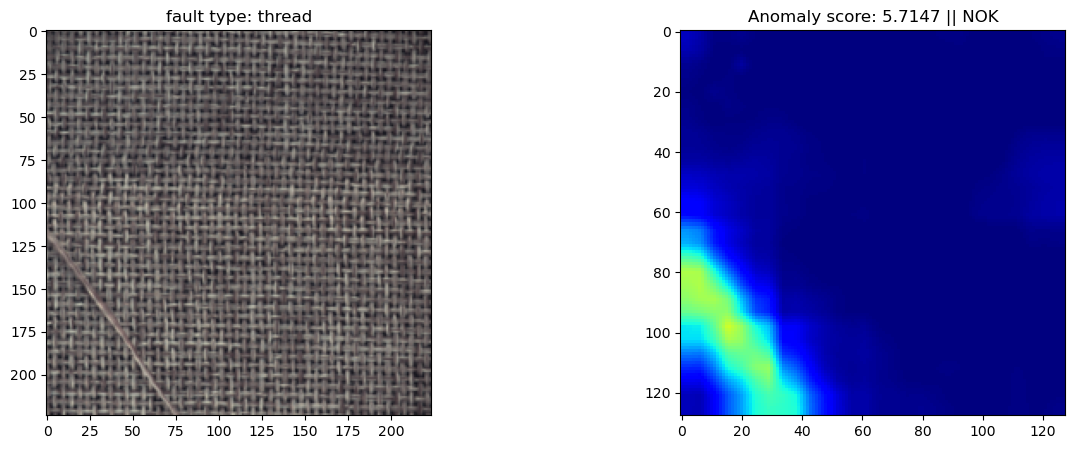

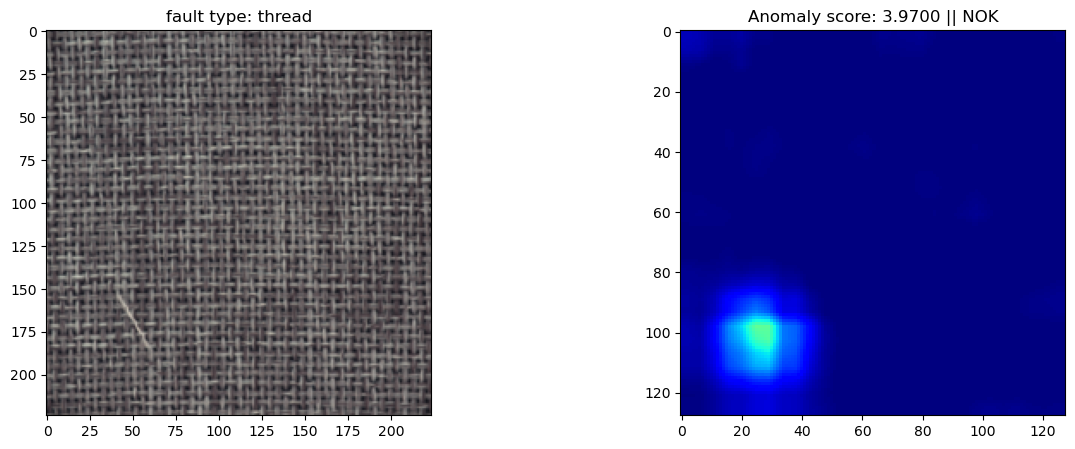

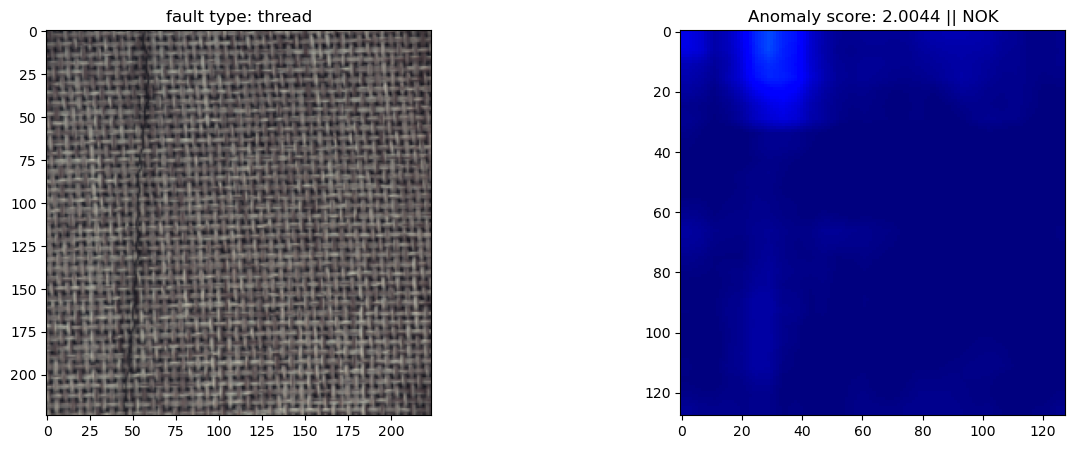

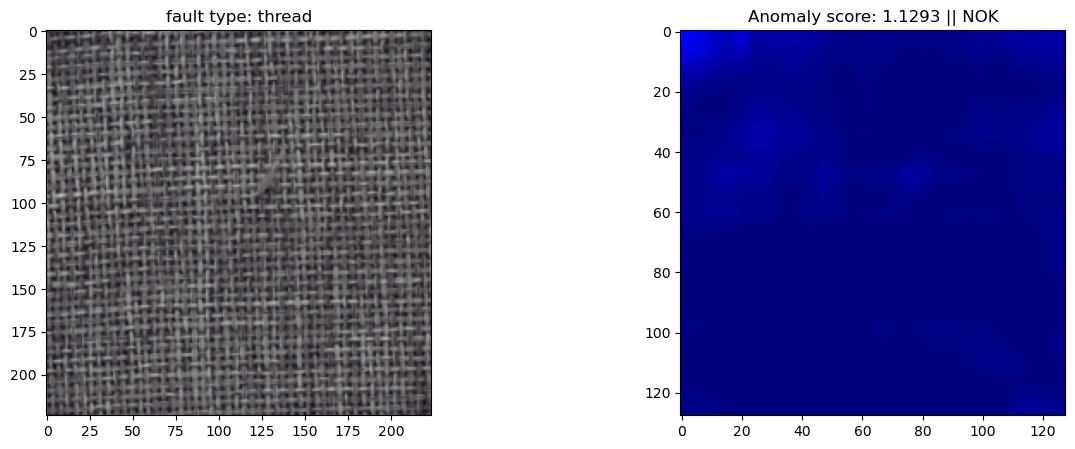

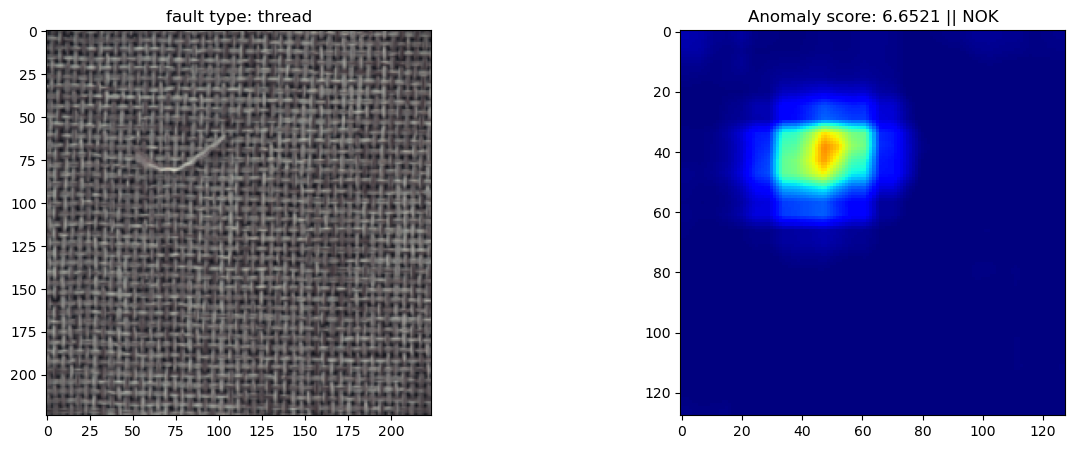

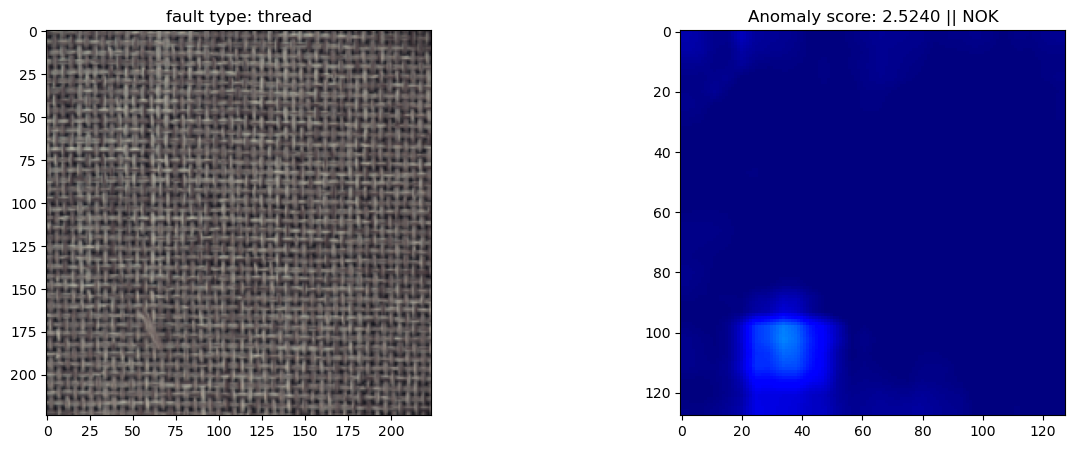

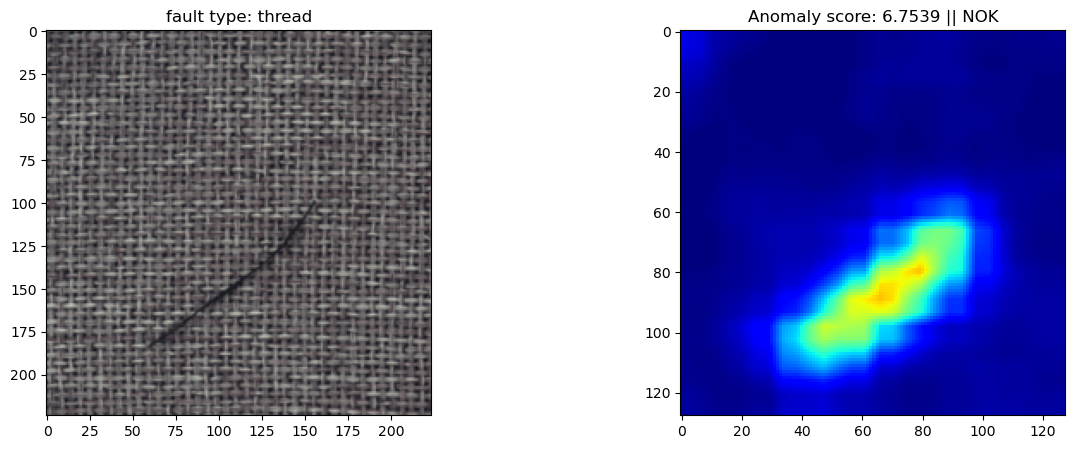

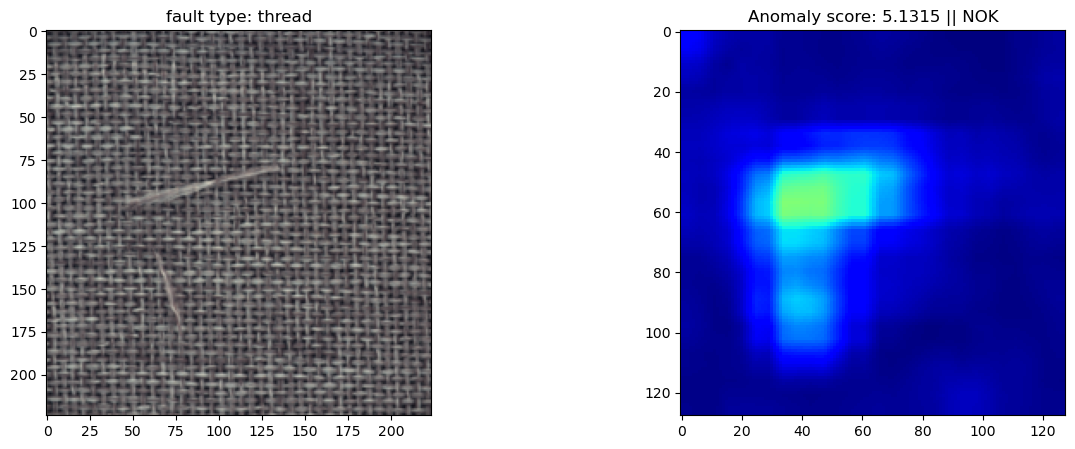

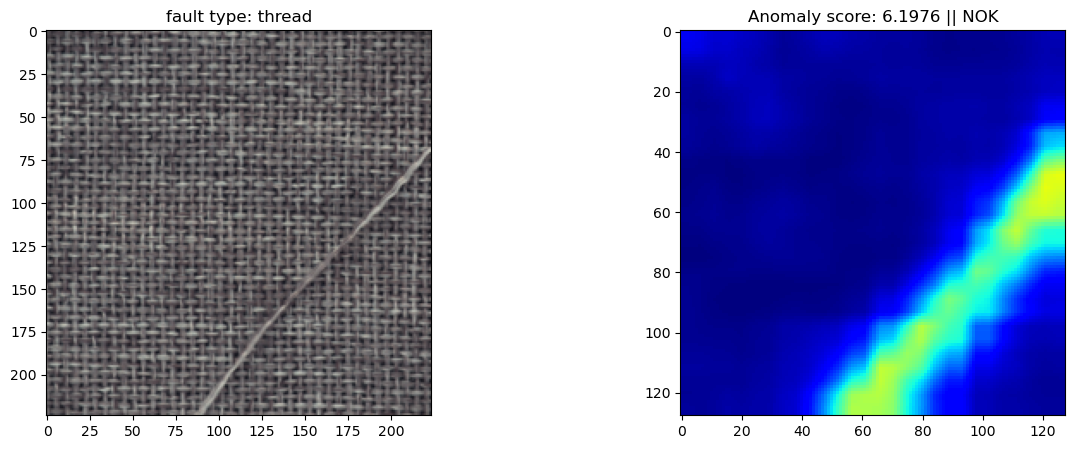

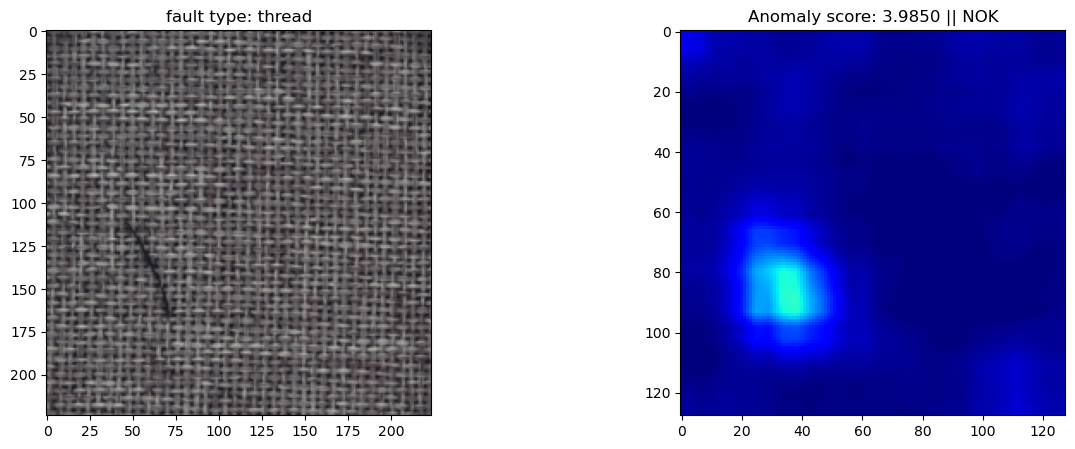

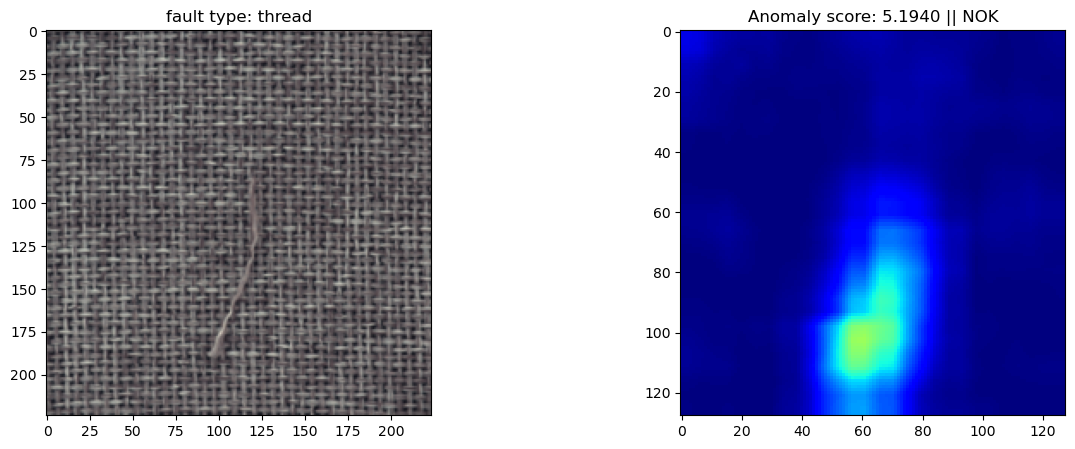

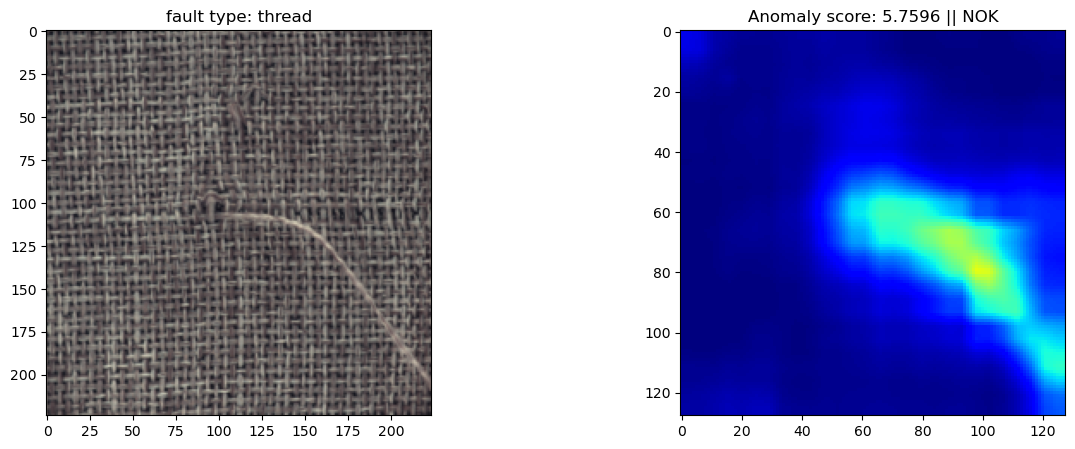

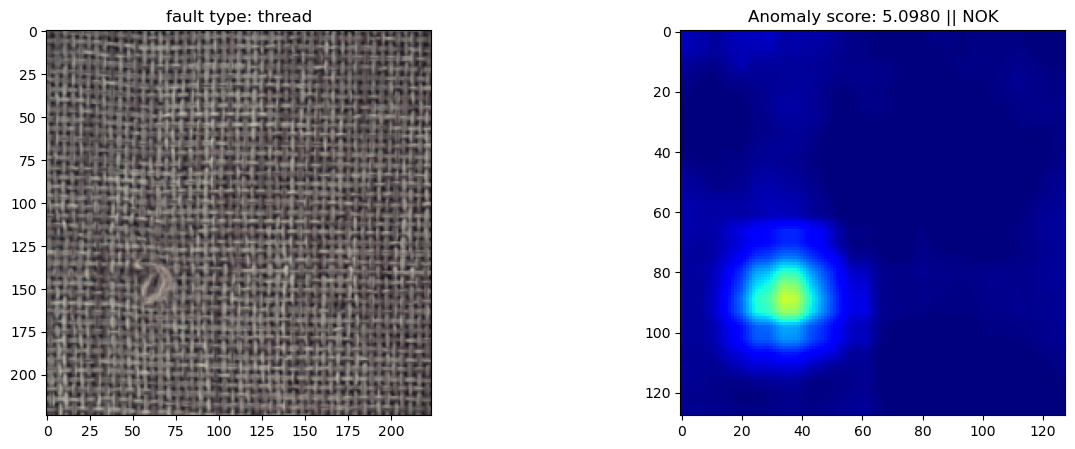

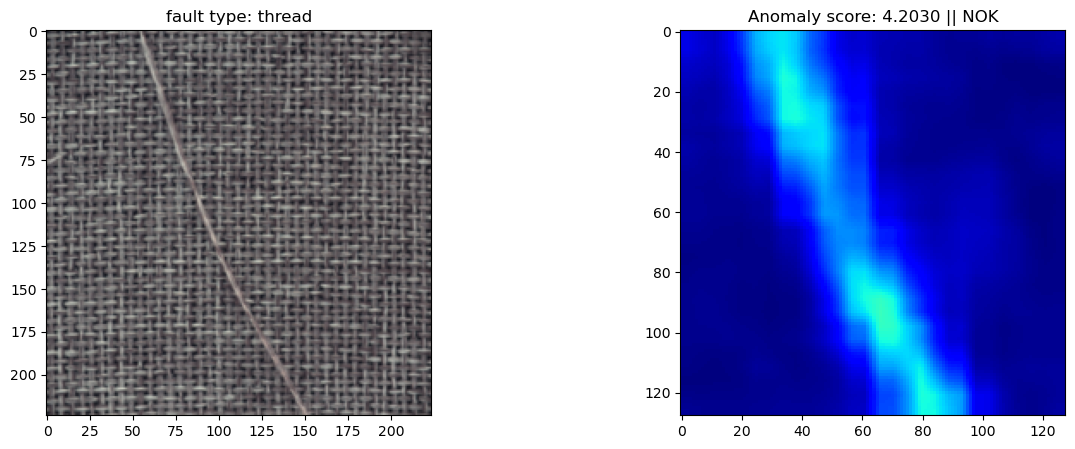

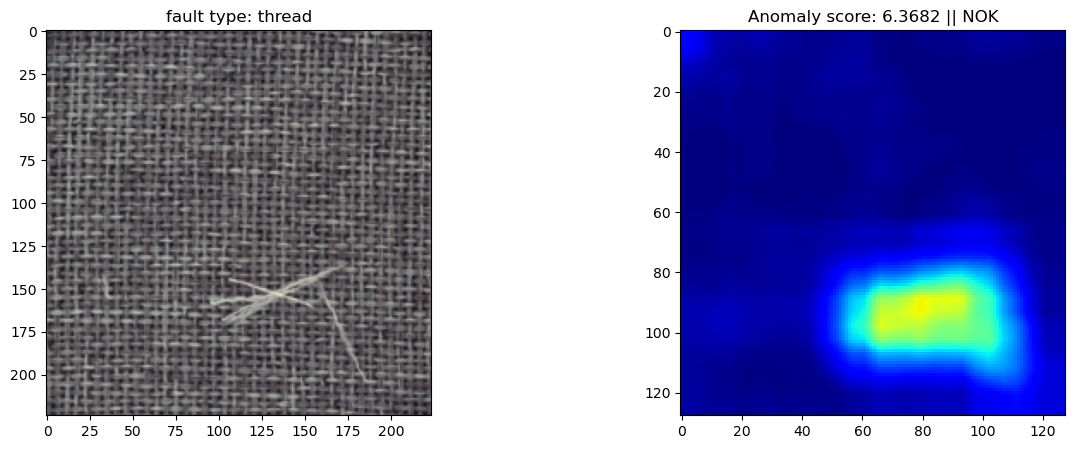

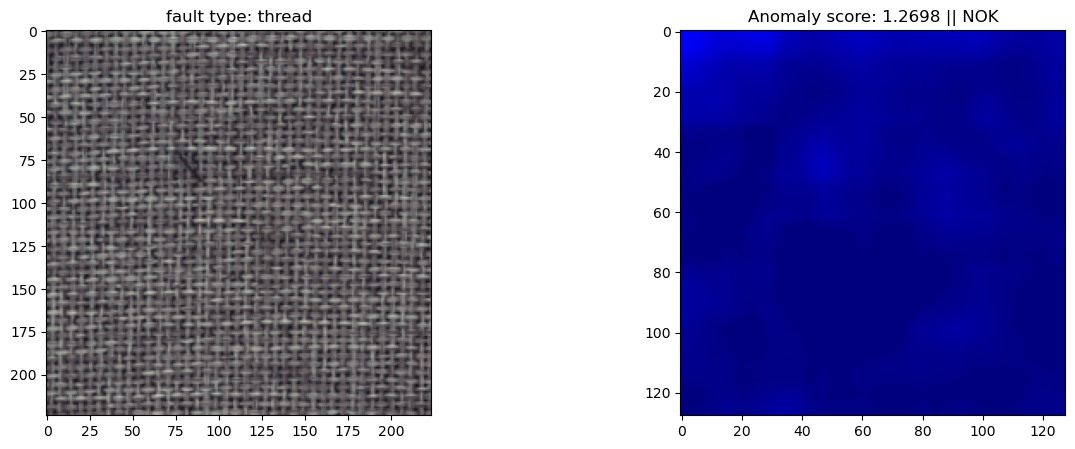

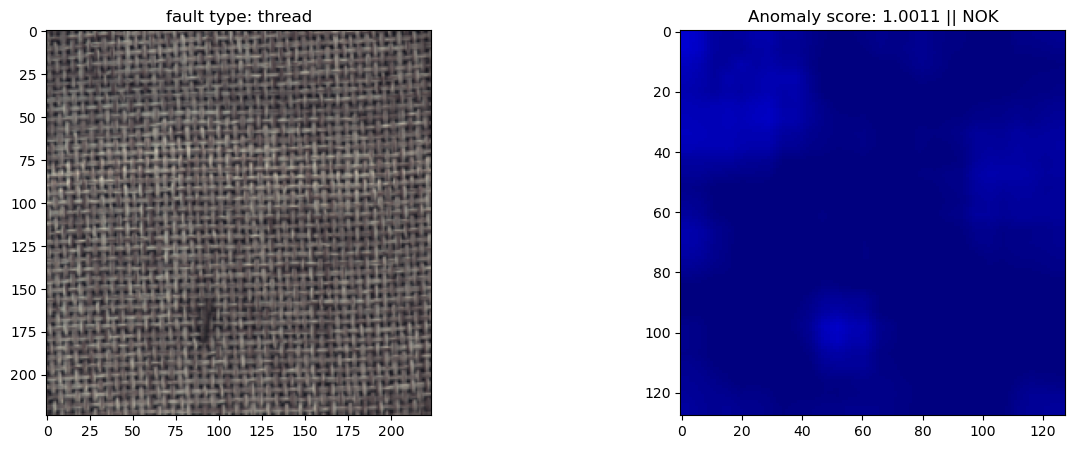

In [67]:
import cv2, time
from IPython.display import clear_output

model.eval()
backbone.eval()

test_path=Path('/Users/mrinalseth13331/Downloads/archive/carpet/test')

for path in test_path.glob('*/*.png'):
    fault_type = path.parts[-2]
    test_image = transform(Image.open(path)).to(device).unsqueeze(0)
    
    with torch.no_grad():
        features = backbone(test_image)
        # Forward pass
        recon = model(features)
    
    segm_map = ((features - recon)**2).mean(axis=(1))
    y_score_image = decision_function(seg_map=segm_map)
    # y_score_image = segm_map.mean(axis=(1,2))
    
    y_pred_image = 1*(y_score_image >= best_threshold)
    class_label = ['OK','NOK']

    if fault_type in ['thread']:

        plt.figure(figsize=(15,5))

        plt.subplot(1,2,1)
        plt.imshow(test_image.squeeze().permute(1,2,0).cpu().numpy())
        plt.title(f'fault type: {fault_type}')

        plt.subplot(1,2,2)
        heat_map = segm_map.squeeze().cpu().numpy()
        heat_map = heat_map
        heat_map = cv2.resize(heat_map, (128,128))
        plt.imshow(heat_map, cmap='jet', vmin=heat_map_min, vmax=heat_map_max*10) # Here I am cheating by multiplying by 10 (obtained using trail error)
        plt.title(f'Anomaly score: {y_score_image[0].cpu().numpy() / best_threshold:0.4f} || {class_label[y_pred_image]}')

        
        
        plt.show()

        # time.sleep(0.05)
        # clear_output(wait=True)

        # break


    